Imports

In [1]:
import findspark
findspark.init()
#necessario per me

In [ ]:
#if necessary:
#pip install category_encoders

In [2]:
import pyspark
import os

from pyspark.sql import SparkSession
from pyspark.sql.types import StructType
from pyspark.sql import functions as F
from pyspark.sql.functions import col, isnan, when, count, array

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler
from pyspark.ml.linalg import Vectors 
from pyspark.ml.classification import RandomForestClassifier, LinearSVC, LogisticRegression, NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator, ClusteringEvaluator
from pyspark.ml.clustering import KMeans

import category_encoders as ce
from sklearn.metrics import confusion_matrix, recall_score, precision_score, roc_auc_score

SparkSession creation

In [3]:
spark = SparkSession.builder.appName("bank churners classification").getOrCreate()

sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=bank churners classification>

CLASSES & FUNCTIONS

In [4]:
class Loader(object):
    def __init__(self, datapath=''):
        self.datapath = datapath
        self.ds_name = None
        self.df = None
    
    def __lshift__(self, name):
        self.ds_name = name
        self.df = spark.read.csv(os.path.join(self.datapath,self.ds_name), header=True, inferSchema=True)
        return self.df

In [5]:
def ordinal_encode(dataframe):
    ordinal_encoder = ce.OrdinalEncoder(cols=['Income_Category','Card_Category','Education_Level','Attrition_Flag'], return_df=True,
    mapping=[{'col':'Income_Category',
    'mapping':{
    'Unknown'        : 0.0,
    'Less than $40K' : 1.0,
    '$40K - $60K'    : 2.0,
    '$60K - $80K'    : 3.0,
    '$80K - $120K'   : 4.0,
    '$120K +'        : 5.0}},

    {'col':'Card_Category',
    'mapping':{
    'Blue'     : 0.0,
    'Silver'   : 1.0,
    'Gold'     : 2.0,
    'Platinum' : 3.0}},

    {'col':'Education_Level',
    'mapping':{
    'Unknown'       : 0.0,
    'Uneducated'    : 1.0,
    'High School'   : 2.0,
    'College'       : 3.0,
    'Graduate'      : 4.0,
    'Post-Graduate' : 5.0,
    'Doctorate'     : 6.0}},

    {'col':'Attrition_Flag',
    'mapping':{
    'Existing Customer' : 0.0,
    'Attrited Customer' : 1.0}}])

    pandas_df = dataframe.toPandas()
    pandas_df = ordinal_encoder.fit_transform(pandas_df)
    df_encoded = spark.createDataFrame(pandas_df)
    return df_encoded

In [6]:
class Preprocessor(object):

    dataframe = property(lambda self: self.df_preprocessed)
    
    def __init__(self, dataframe):
        self.df = dataframe
        self.df_dropped = self.drop_columns()
        self.df_na = self.count_missing_values()
        self.features = []
        self.col_qual = []
        self.df_quant = None
        self.df_encoded = self.encode_nominal_feat()
        self.df_preprocessed = self.assemble_and_scale(keep_cols = 'sì')
        
        
    def drop_columns(self):
        return self.df.drop('CLIENTNUM','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2')
    
    def count_missing_values(self):
        return self.df_dropped.select([count(when(col(c).contains('None') | col(c).contains('NULL') | (col(c) == '' ) | col(c).isNull() | isnan(c), c)).alias(c)
                    for c in self.df_dropped.columns])
    
    def find_missing_values(self):
        dict_na = self.df_na.collect()[0].asDict()
        if len(set(dict_na.values())) == 1 and list(set(dict_na.values()))[0] == 0:
            print('there are no missing values')
        else:
            print('there are some missing values, check further:')
            self.df_na.show()
    
    def show_summary(self):
        self.col_qual = [c for c in self.df_dropped.columns if dict(self.df_dropped.dtypes)[c] == 'string']
        self.df_quant = self.df_dropped.drop(*self.col_qual)
        for c in self.col_qual:
            self.df_dropped.groupBy(c).count().sort(col('count').desc()).withColumn('percentage', F.round((F.col('count') / self.df_dropped.count()) * 100, 2 )).show()
        self.df_quant.describe().show()

    def encode_nominal_feat(self):
        ord_encoded = ordinal_encode(self.df_dropped)
        indexer = StringIndexer(inputCols=('Gender','Marital_Status'), outputCols=('GenderNDX','Marital_StatusNDX'))
        indexed = indexer.fit(ord_encoded).transform(ord_encoded)
        encoder = OneHotEncoder(inputCols=('GenderNDX', 'Marital_StatusNDX'), outputCols=('GenderOHE', 'Marital_StatusOHE'))
        encoded = encoder.fit(indexed).transform(indexed)
        #encoded = encoded.drop('GenderNDX','Marital_StatusNDX')
        return encoded

    def assemble_and_scale(self, keep_cols = 'no'):
        self.features = [x for x in self.df_encoded.columns]
        for f in ['Attrition_Flag','Gender','Marital_Status','GenderNDX','Marital_StatusNDX']:
            self.features.remove(f)
        
        assembler = VectorAssembler(inputCols=self.features, outputCol="Xs")
        assembled = assembler.transform(self.df_encoded)
        scaler = MinMaxScaler(inputCol="Xs", outputCol="scaled_features")
        scaler_fitting = scaler.fit(assembled)
        scaled = scaler_fitting.transform(assembled)
        if keep_cols in ['yes','si', 'sì']:
            return scaled
        else:
            return scaled.select('Xs','scaled_features','Attrition_Flag')

In [7]:
class Graphics_maker(object):

    def __init__(self, dataframe):
        self.df = dataframe
        self.pandas_df = dataframe.toPandas()
        self.var_quant = self.get_var_quant()
    
    def get_var_quant(self):
        col_quant = [c for c in self.df.columns if dict(self.df.dtypes)[c] in ' integer ' or dict(self.df.dtypes)[c] in ' double ']
        col_quant = col_quant[1:]
        return col_quant
        
    def make_histograms(self):
        for c in self.var_quant:
            hist = self.pandas_df.hist(column = c)
    
    def check_distribution(self, column_name = str):
        stats.probplot(self.pandas_df[column_name], dist='norm', plot=plt)
        plt.title('{} vs Normal Q-Q plot'.format(column_name))
        plt.show()

In [8]:
class MyRandomForest(object):
    
    def __init__(self, features):
        self.features = features
        self.rf = RandomForestClassifier(maxDepth=10, numTrees=100, featuresCol='Xs', labelCol='Attrition_Flag')
        self.strict_results = {}
        self.model = None
        self.predictions = None
        self.test_y = []
        self.pred_y = []


    def fit(self, training_set):
        self.model = self.rf.fit(training_set)
        return self.model


    def transform(self, test_set):
        self.predictions = self.model.transform(test_set)
        self.test_y = [row['Attrition_Flag'] for row in test_set.collect()]
        self.pred_y = [row['prediction'] for row in self.predictions.collect()]
        return self.predictions


    def set_most_important_features(self):
        self.strict_results['most_imp_xs'] = {self.features[k] : i for k, i in enumerate(self.model.featureImportances) if i >= 0.1}

    
    def classify_with_threshold(self, threshold = float):    
        pred_strict = [0 if row['probability'][1] < threshold else 1 for row in self.predictions.collect()]
        self.strict_results['conf_mat_{}_perc'.format(threshold)] = confusion_matrix(self.test_y, pred_strict)
        self.strict_results['recall_{}_perc'.format(threshold)] = round(recall_score(y_pred = pred_strict, y_true = self.test_y), 2)
        self.strict_results['precision_{}_perc'.format(threshold)] = round(precision_score(y_pred = pred_strict, y_true = self.test_y), 2)
        tn, fp, fn, tp = confusion_matrix(self.test_y, pred_strict).ravel()
        self.strict_results['false_positive_rate_{}_perc'.format(threshold)] = round(fp / (tn + fp), 2)
        self.strict_results['auc_roc_{}_perc'.format(threshold)] = round(roc_auc_score(y_score = pred_strict, y_true = self.test_y), 2)
        return self.strict_results
        

In [9]:
class ExperimentHandler(object):
    
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.training_set = self.dataframe.sampleBy("Attrition_Flag", fractions={0.0: 0.8, 1.0: 0.8}, seed=10)
        self.test_set = self.dataframe.subtract(self.training_set)
        
        self.alias = {'random_forest': ('randomforest', 'random_forest', 'rf'), 'svm': ('svc', 'svm'),
                      'logistic_regression': ('logistic_regression', 'log_reg'),
                      'naive_bayes': ('naive_bayes','nb','naivebayes')}
        
        self.classifiers = dict()
        self.results = dict()
        
    def add_classifier(self, name, classifier): #per inserire classificatori dall'esterno
        name = name.lower()
        for k, alias in self.alias.items():
            if name in alias: name = k
        self.classifiers[name] = classifier
        
        
    def start_classifications(self):
        for name, classifier in self.classifiers.items():
            self.results[name] = self.classify(name, classifier)
        return self.results


    def classify(self, name, classifier): 
        output = {}
        model = classifier.fit(self.training_set)
        predictions = model.transform(self.test_set)
        
        evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='Attrition_Flag')
        output['accuracy'] = round(evaluator.evaluate(predictions), 2)
        test_y = [row['Attrition_Flag'] for row in self.test_set.collect()]
        pred_y = [row['prediction'] for row in predictions.collect()]
        
        output['recall'] = round(recall_score(y_pred = pred_y, y_true = test_y), 2)
        output['precision'] = round(precision_score(y_pred = pred_y, y_true = test_y), 2)
        output['conf_mat'] = confusion_matrix(test_y, pred_y)

        tn, fp, fn, tp = confusion_matrix(test_y, pred_y).ravel()
        output['false_positive_rate'] = round(fp / (tn + fp), 2)
        output['auc_roc'] = round(roc_auc_score(y_score = pred_y, y_true = test_y), 2)
        return output

In [10]:
class Clusterer(object):

    def __init__(self, df):
        self.df = df
        self.best_clustering = {}
        self.prediction_df = spark.createDataFrame([], StructType([])) #inizializza un df vuoto
        self.summary = self.perform_cluster_analysis()


    def perform_cluster_analysis(self):
        evaluator = ClusteringEvaluator(featuresCol='scaled_features')
        silhouettes = []
        for c in range(2,6):
            kmeans = KMeans(featuresCol='scaled_features', k=c)
            model = kmeans.fit(self.df)
            predictions = model.transform(self.df)
            silhouette = evaluator.evaluate(predictions)
            silhouettes.append(round(silhouette,5))
        return silhouettes


    def draw_elbow(self):
        plt.plot(range(2,6), self.summary)


    def take_best_clustering(self):
        self.best_clustering['number of clusters'] = self.summary.index(max(self.summary)) +2
        kmeans = KMeans(featuresCol='scaled_features', k=self.best_clustering['number of clusters'])
        model = kmeans.fit(self.df)
        self.prediction_df = model.transform(self.df)
        self.best_clustering['centers'] = model.clusterCenters()
        self.best_clustering['distribution'] = self.prediction_df.groupBy('prediction').count().sort(col('count').desc()).withColumn('percentage', F.round((F.col('count') / self.prediction_df.count()) * 100, 2 ))
        attrition_flag = [row['Attrition_Flag'] for row in self.prediction_df.collect()]
        preds = [row['prediction'] for row in self.prediction_df.collect()]
        self.best_clustering['conf_mat churn vs clust'] = confusion_matrix(attrition_flag, preds)
        if self.best_clustering['number of clusters'] == 2:
            self.best_clustering['tn, fp, fn, tp'] = confusion_matrix(attrition_flag, preds).ravel()
        return self.best_clustering
    
    def get_clustering_insights(self):
        useless_feat = ('Xs', 'scaled_features', 'Attrition_Flag', 'prediction', 'GenderOHE', 'Marital_StatusOHE', 'Marital_StatusNDX')
        quant_feat_list = [c for c in self.prediction_df.columns if c not in useless_feat
                       and dict(self.prediction_df.dtypes)[c] != 'string']

        qual_feat_list = [c for c in self.prediction_df.columns if c not in useless_feat
                            and c not in quant_feat_list]
        
        for c in quant_feat_list:
            df_summary = self.prediction_df.groupby('prediction').agg(F.count(c).alias('count'),
            F.mean(c).alias('mean'),
            F.stddev(c).alias('std'),
            F.min(c).alias('min'),
            F.expr('percentile({}, array(0.25))'.format(c))[0].alias('%25'),
            F.expr('percentile({}, array(0.5))'.format(c))[0].alias('%50'),
            F.expr('percentile({}, array(0.75))'.format(c))[0].alias('%75'),
            F.max(c).alias('max'))
            print(c)
            df_summary.show(truncate = False)
        
        for c in qual_feat_list:
            df_summary = self.prediction_df.groupby('prediction', c).count().sort(col('count').desc()).withColumn('percentage', F.round((F.col('count') / self.prediction_df.count()) * 100, 2 ))
            print(c)
            df_summary.show(truncate = False)

CODE TO BE EXECUTED

In [11]:
df = Loader(".\data") << "BankChurners.csv"

In [12]:
df.head(2)

[Row(CLIENTNUM=768805383, Attrition_Flag='Existing Customer', Customer_Age=45, Gender='M', Dependent_count=3, Education_Level='High School', Marital_Status='Married', Income_Category='$60K - $80K', Card_Category='Blue', Months_on_book=39, Total_Relationship_Count=5, Months_Inactive_12_mon=1, Contacts_Count_12_mon=3, Credit_Limit=12691.0, Total_Revolving_Bal=777, Avg_Open_To_Buy=11914.0, Total_Amt_Chng_Q4_Q1=1.335, Total_Trans_Amt=1144, Total_Trans_Ct=42, Total_Ct_Chng_Q4_Q1=1.625, Avg_Utilization_Ratio=0.061, Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1=9.3448e-05, Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2=0.99991),
 Row(CLIENTNUM=818770008, Attrition_Flag='Existing Customer', Customer_Age=49, Gender='F', Dependent_count=5, Education_Level='Graduate', Marital_Status='Single', Income_Category='Less than $40K', Card

In [13]:
preprocess = Preprocessor(df)
preprocess.show_summary()

+-----------------+-----+----------+
|   Attrition_Flag|count|percentage|
+-----------------+-----+----------+
|Existing Customer| 8500|     83.93|
|Attrited Customer| 1627|     16.07|
+-----------------+-----+----------+

+------+-----+----------+
|Gender|count|percentage|
+------+-----+----------+
|     F| 5358|     52.91|
|     M| 4769|     47.09|
+------+-----+----------+

+---------------+-----+----------+
|Education_Level|count|percentage|
+---------------+-----+----------+
|       Graduate| 3128|     30.89|
|    High School| 2013|     19.88|
|        Unknown| 1519|      15.0|
|     Uneducated| 1487|     14.68|
|        College| 1013|      10.0|
|  Post-Graduate|  516|       5.1|
|      Doctorate|  451|      4.45|
+---------------+-----+----------+

+--------------+-----+----------+
|Marital_Status|count|percentage|
+--------------+-----+----------+
|       Married| 4687|     46.28|
|        Single| 3943|     38.94|
|       Unknown|  749|       7.4|
|      Divorced|  748|      7.

commento a 'process.show_summary()':
Income_Category, Card_Category, Education_Level sono variabili categoriche ORDINALI, mentre Marital_Status e Gender sono NOMINALI. Bisogna tenerlo in considerazione per la codifica migliore.

le colonne 'Education_Level', 'Marital_Status' e 'Income_Category' presentano valori 'unknown' come gestirli? Consideriamo unknown una classe come le altre o potremmo classificare le osservazioni in base alle altre features con KNN o altri classificatori.

per quanto riguarda la y (attrition yes or no) il ds è fortemente sbilanciato su no (positivo per la banca), dovremo tener in considerazione questa condizione nel momento di splittare il ds in train e test. Il genere è abbastanza bilanciato. Solo il 14% dei clienti non ha istruzione superiore ma per un 15% non abbiamo dati. Il 35% guadagna meno di 40k all'anno e solo il 7% più di 120k. La maggior parte dei clienti appartiene alla categoria base 'blue'.


In [14]:
df_dropped = preprocess.df_dropped

In [15]:
df_dropped.columns

['Attrition_Flag',
 'Customer_Age',
 'Gender',
 'Dependent_count',
 'Education_Level',
 'Marital_Status',
 'Income_Category',
 'Card_Category',
 'Months_on_book',
 'Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Credit_Limit',
 'Total_Revolving_Bal',
 'Avg_Open_To_Buy',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Amt',
 'Total_Trans_Ct',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio']

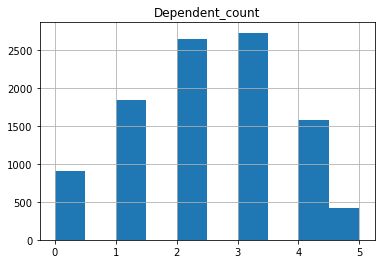

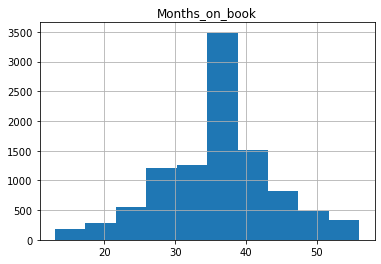

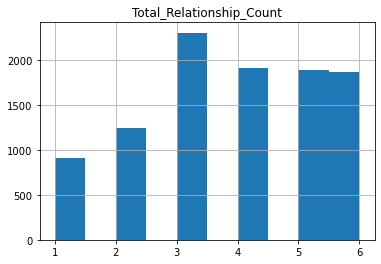

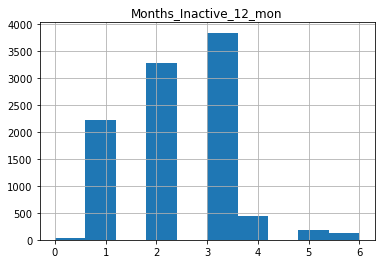

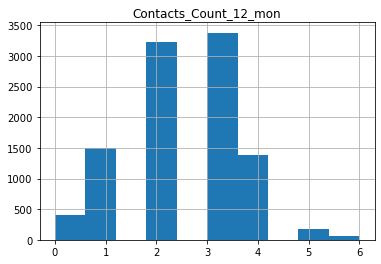

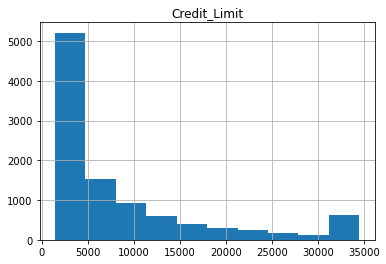

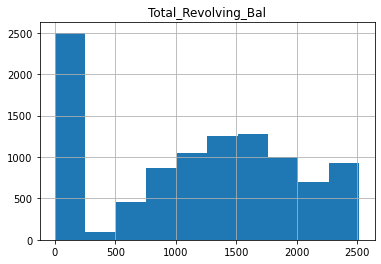

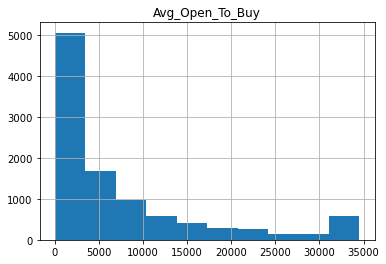

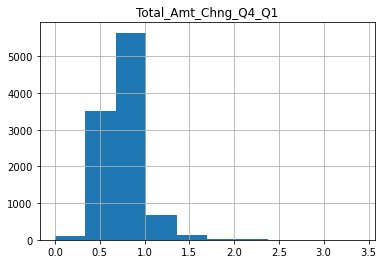

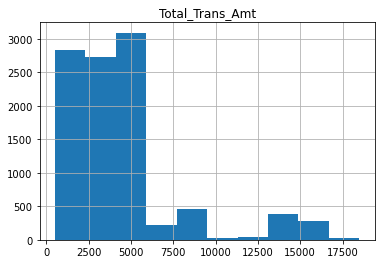

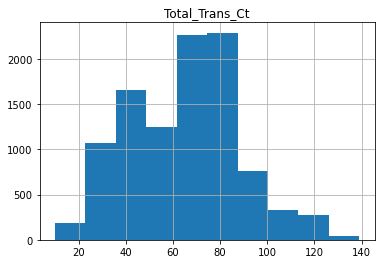

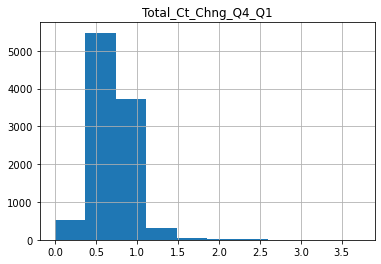

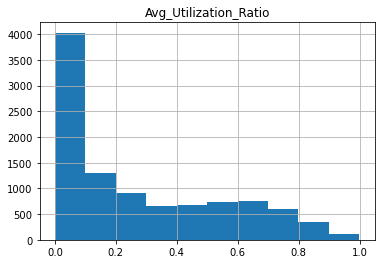

In [16]:
graph = Graphics_maker(df_dropped)
graph.make_histograms()

In [17]:
graph.var_quant

['Dependent_count',
 'Months_on_book',
 'Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Credit_Limit',
 'Total_Revolving_Bal',
 'Avg_Open_To_Buy',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Amt',
 'Total_Trans_Ct',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio']

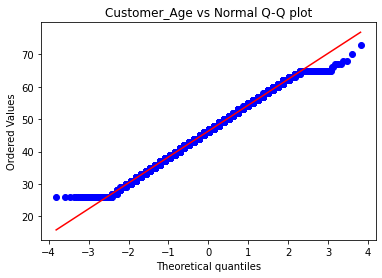

In [18]:
graph.check_distribution('Customer_Age')

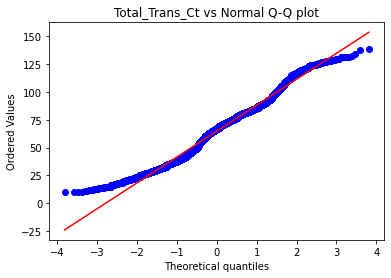

In [19]:
graph.check_distribution('Total_Trans_Ct')

Solo la distribuzione di frequenza della var Customer_Age sembra avvicinarsi a una normale, Months_on_book ha elevata curtosi,
Credit_limit ha la coda di destra lunga = sbilanciata a sinistra media > mediana, ma i valori ampi sono comunque plausibili, Avg_Open_To_Buy sembra essere molto correlata a Credit_Limit.
Total_Trans_Amt è molto sbilanciata a sinistra ma presenta tre campane.
Customer_Age è distribuita come una normale nei valori centrali, ma non è approssimata bene nelle code

In [20]:
encoded = preprocess.df_encoded
encoded.show(2)

+--------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+---------+-----------------+-------------+-----------------+
|Attrition_Flag|Customer_Age|Gender|Dependent_count|Education_Level|Marital_Status|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|GenderNDX|Marital_StatusNDX|    GenderOHE|Marital_StatusOHE|
+--------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+--------------------

In [21]:
assembled = preprocess.dataframe

dataframe keeps the columns that have been assembled, this will result useful later, for the interpretation of cluster analysis.

In [22]:
assembled.show(2, truncate = False)

+--------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+---------+-----------------+-------------+-----------------+-----------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Attrition_Flag|Customer_Age|Gender|Dependent_count|Education_Level|Marital_Status|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_

In [23]:
feat_list = preprocess.features

In [24]:
feat_list

['Customer_Age',
 'Dependent_count',
 'Education_Level',
 'Income_Category',
 'Card_Category',
 'Months_on_book',
 'Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Credit_Limit',
 'Total_Revolving_Bal',
 'Avg_Open_To_Buy',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Amt',
 'Total_Trans_Ct',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio',
 'GenderOHE',
 'Marital_StatusOHE']

to create the list of features names will be useful later to know which are the most informative features from Random Forest

In [25]:
exp_handler = ExperimentHandler(assembled)

In [26]:
exp_handler.add_classifier(name='rf', classifier=MyRandomForest(feat_list))

In [27]:
exp_handler.add_classifier(name='svm', classifier=LinearSVC(maxIter=100, featuresCol="scaled_features", labelCol="Attrition_Flag", regParam=0.0, threshold=-1.1))
#regParam se > 0, tipo 0.1 allora introduciamo penalty

In [28]:
exp_handler.add_classifier(name='Log_reg', classifier=LogisticRegression(featuresCol="scaled_features", labelCol='Attrition_Flag', threshold=0.25))

In [29]:
exp_handler.add_classifier(name='Naive_bayes', classifier=NaiveBayes(featuresCol='Xs', labelCol='Attrition_Flag', thresholds= [0.75, 0.25]))

In [30]:
exp_handler.classifiers

{'random_forest': <__main__.MyRandomForest at 0x1f40b6af100>,
 'svm': LinearSVC_e0fa74bca960,
 'logistic_regression': LogisticRegression_c51b728cb292,
 'naive_bayes': NaiveBayes_1cd0e170cc2c}

In [31]:
results = exp_handler.start_classifications()

In [32]:
for name, summary in results.items():
    print(name, summary)

random_forest {'accuracy': 0.9, 'recall': 0.82, 'precision': 0.9, 'conf_mat': array([[1709,   28],
       [  57,  262]], dtype=int64), 'false_positive_rate': 0.02, 'auc_roc': 0.9}
svm {'accuracy': 0.85, 'recall': 0.87, 'precision': 0.48, 'conf_mat': array([[1440,  297],
       [  40,  279]], dtype=int64), 'false_positive_rate': 0.17, 'auc_roc': 0.85}
logistic_regression {'accuracy': 0.85, 'recall': 0.81, 'precision': 0.56, 'conf_mat': array([[1539,  198],
       [  62,  257]], dtype=int64), 'false_positive_rate': 0.11, 'auc_roc': 0.85}
naive_bayes {'accuracy': 0.55, 'recall': 0.42, 'precision': 0.2, 'conf_mat': array([[1192,  545],
       [ 186,  133]], dtype=int64), 'false_positive_rate': 0.31, 'auc_roc': 0.55}


How to correctly read confusion matrix: the rows are the reality, row 1 = 0 and row 2 = 1, the columns are the predictions

In [40]:
my_rf = exp_handler.classifiers['random_forest']

In [41]:
my_rf.fit(exp_handler.training_set)

RandomForestClassificationModel: uid=RandomForestClassifier_88aba430e1b2, numTrees=100, numClasses=2, numFeatures=21

In [42]:
my_rf.set_most_important_features()

In [43]:
my_rf.transform(exp_handler.test_set)

DataFrame[Attrition_Flag: bigint, Customer_Age: bigint, Gender: string, Dependent_count: bigint, Education_Level: bigint, Marital_Status: string, Income_Category: bigint, Card_Category: bigint, Months_on_book: bigint, Total_Relationship_Count: bigint, Months_Inactive_12_mon: bigint, Contacts_Count_12_mon: bigint, Credit_Limit: double, Total_Revolving_Bal: bigint, Avg_Open_To_Buy: double, Total_Amt_Chng_Q4_Q1: double, Total_Trans_Amt: bigint, Total_Trans_Ct: bigint, Total_Ct_Chng_Q4_Q1: double, Avg_Utilization_Ratio: double, GenderNDX: double, Marital_StatusNDX: double, GenderOHE: vector, Marital_StatusOHE: vector, Xs: vector, scaled_features: vector, rawPrediction: vector, probability: vector, prediction: double]

In [44]:
my_rf_results = my_rf.classify_with_threshold(0.25)
my_rf_results

{'most_imp_xs': {'Total_Revolving_Bal': 0.11794627811664221,
  'Total_Trans_Amt': 0.17659357201499737,
  'Total_Trans_Ct': 0.1972125105448072,
  'Total_Ct_Chng_Q4_Q1': 0.1068156148600973},
 'conf_mat_0.25_perc': array([[1650,   87],
        [  15,  304]], dtype=int64),
 'recall_0.25_perc': 0.95,
 'precision_0.25_perc': 0.78,
 'false_positive_rate_0.25_perc': 0.05,
 'auc_roc_0.25_perc': 0.95}

In [44]:
cl = Clusterer(assembled)

In [45]:
cl.summary

[0.36034, 0.3621, 0.36938, 0.40732]

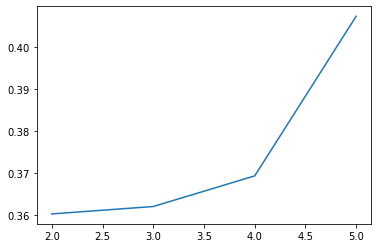

In [46]:
cl.draw_elbow()

In [124]:
cl_results = cl.take_best_clustering()

In [125]:
cl_results

{'number of clusters': 2,
 'centers': [array([0.44117046, 0.47326648, 0.43794894, 0.42470664, 0.02197568,
         0.53986038, 0.56820994, 0.3889126 , 0.40953702, 0.20068995,
         0.47563117, 0.19924371, 0.22735117, 0.20381762, 0.40097218,
         0.19270881, 0.28993961, 0.52293578, 1.        , 0.        ,
         0.        ]),
  array([0.42496871, 0.46577206, 0.42996324, 0.410625  , 0.03296569,
         0.52749658, 0.55761029, 0.39129902, 0.40894608, 0.23194123,
         0.45022611, 0.23104811, 0.22057162, 0.22770812, 0.44618816,
         0.19095543, 0.26244241, 0.534375  , 0.        , 0.72481618,
         0.13768382])],
 'distribution': DataFrame[prediction: int, count: bigint, percentage: double],
 'conf_mat churn vs clust': array([[3978, 4522],
        [ 709,  918]], dtype=int64),
 'tn, fp, fn, tp': array([3978, 4522,  709,  918], dtype=int64)}

In [126]:
cl_results['distribution'].show()

+----------+-----+----------+
|prediction|count|percentage|
+----------+-----+----------+
|         1| 5440|     53.72|
|         0| 4687|     46.28|
+----------+-----+----------+



In [127]:
cl.get_clustering_insights()

Customer_Age
+----------+-----+-----------------+-----------------+---+----+----+----+---+
|prediction|count|mean             |std              |min|%25 |%50 |%75 |max|
+----------+-----+-----------------+-----------------+---+----+----+----+---+
|1         |5440 |45.97352941176471|8.220331704080673|26 |40.0|46.0|52.0|65 |
|0         |4687 |46.73501173458502|7.754734824679689|26 |41.0|47.0|52.0|73 |
+----------+-----+-----------------+-----------------+---+----+----+----+---+

Dependent_count
+----------+-----+------------------+------------------+---+---+---+---+---+
|prediction|count|mean              |std               |min|%25|%50|%75|max|
+----------+-----+------------------+------------------+---+---+---+---+---+
|1         |5440 |2.3288602941176473|1.3087925137532461|0  |1.0|2.0|3.0|5  |
|0         |4687 |2.366332408790271 |1.2871875310535295|0  |1.0|2.0|3.0|5  |
+----------+-----+------------------+------------------+---+---+---+---+---+

Education_Level
+----------+-----+-----

+----------+-----+------------------+------------------+---+-----+-----+-------+-----+
|prediction|count|mean              |std               |min|%25  |%50  |%75    |max  |
+----------+-----+------------------+------------------+---+-----+-----+-------+-----+
|1         |5440 |0.2621799632352942|0.2726568823198362|0.0|0.0  |0.155|0.48125|0.999|
|0         |4687 |0.2896496692980585|0.2784743727177793|0.0|0.034|0.199|0.523  |0.994|
+----------+-----+------------------+------------------+---+-----+-----+-------+-----+

GenderNDX
+----------+-----+-------------------+------------------+---+---+---+---+---+
|prediction|count|mean               |std               |min|%25|%50|%75|max|
+----------+-----+-------------------+------------------+---+---+---+---+---+
|1         |5440 |0.465625           |0.4988628132597098|0.0|0.0|0.0|1.0|1.0|
|0         |4687 |0.47706422018348627|0.4995269643870582|0.0|0.0|0.0|1.0|1.0|
+----------+-----+-------------------+------------------+---+---+---+---+---+

The cluster division separates the observation in two groups: do they coincide with the churners and not churners? No, the results from cluster analysis show that the confusion matrix between the response's category and the clusters is quite poor.
Getting more stats about the two clusters is useful to understand which are their main features. To summarize them: cluster zero corresponds to merried people with a slightly lower 'card category', 'credit limit' and amount of transactions.